##### import libs

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR

c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Settings

In [3]:
# Path to the Turkey Retail Sales Data CSV file
data_path = r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\Turkey_Retail Sales Data_1048576\sales\turkey_sales.csv'

In [4]:
# Read the CSV file in chunks of 100 rows each
reader = pd.read_csv(data_path, low_memory=False, chunksize=100)

# Iterate over each chunk and print the first few rows
for i, chunk in enumerate(reader):
    # Print the chunk number
    print(f"Chunk {i+1}:")
    
    # Print the first few rows of the current chunk
    print(chunk.head())
    
    # Check if it's the first chunk and exit the loop
    if i == 0:
        break

Chunk 1:
  product_id store_id        date  sales  revenue  stock  price promo_type_1  \
0      P0001    S0002  2017-01-02    0.0     0.00    8.0   6.25         PR14   
1      P0001    S0012  2017-01-02    1.0     5.30    0.0   6.25         PR14   
2      P0001    S0013  2017-01-02    2.0    10.59    0.0   6.25         PR14   
3      P0001    S0023  2017-01-02    0.0     0.00    6.0   6.25         PR14   
4      P0001    S0025  2017-01-02    0.0     0.00    1.0   6.25         PR14   

   promo_bin_1 promo_type_2  promo_bin_2  promo_discount_2  \
0          NaN         PR03          NaN               NaN   
1          NaN         PR03          NaN               NaN   
2          NaN         PR03          NaN               NaN   
3          NaN         PR03          NaN               NaN   
4          NaN         PR03          NaN               NaN   

   promo_discount_type_2  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4 

#### get count of each column unique values

In [5]:
# Specify the chunk size for reading the CSV file
chunksize = 1000  

# Create a DataFrame iterator to read the CSV file in chunks
reader = pd.read_csv(data_path, low_memory=False, chunksize=chunksize)

# Initialize an empty dictionary to store unique values for each column
unique_values = {}

# Iterate over each chunk in the DataFrame
for i, chunk in enumerate(reader):
    # Concatenate the chunk to the dictionary of unique values
    if i == 0:
        # For the first chunk, initialize the dictionary with the unique values of the first chunk
        unique_values = {col: chunk[col].unique() for col in chunk.columns}
    else:
        # For subsequent chunks, update the dictionary with the unique values of each column
        for col in chunk.columns:
            unique_values[col] = pd.unique(pd.concat([pd.Series(unique_values[col]), chunk[col]], ignore_index=True))

# Convert dictionary keys and lengths of lists into a DataFrame
df = pd.DataFrame({'Column Name': list(unique_values.keys()), 'Length': [len(values) for values in unique_values.values()]})

# Display the DataFrame containing unique values for each column
df

,Column Name,Length
0,product_id,649
1,store_id,144
2,date,1092
3,sales,6189
4,revenue,14114
5,stock,12813
6,price,633
7,promo_type_1,17
8,promo_bin_1,6
9,promo_type_2,4


#### fetch all 25 top revenue contributing store_ids

In [6]:
# Initialize an empty dictionary to store total revenue for each store
store_revenue = {}

# Iterate over the dataset in chunks
for chunk in pd.read_csv(data_path, low_memory=False, chunksize=1000):
    # Calculate total revenue for each store in the current chunk
    chunk_revenue = chunk.groupby('store_id')['revenue'].sum().to_dict()
    
    # Update the dictionary with total revenue for each store
    for store_id, revenue in chunk_revenue.items():
        store_revenue[store_id] = store_revenue.get(store_id, 0) + revenue

# Convert the dictionary to a DataFrame
df_total_revenue = pd.DataFrame(list(store_revenue.items()), columns=['store_id', 'total_revenue'])

# Sort the DataFrame by total_revenue column
df_total_revenue_sorted = df_total_revenue.sort_values(by='total_revenue', ascending=False)

# Calculate the total revenue across all stores
total_revenue_all_stores = df_total_revenue_sorted['total_revenue'].sum()

# Calculate percentage revenue contribution for each store
df_total_revenue_sorted['percentage_contribution'] = (df_total_revenue_sorted['total_revenue'] / total_revenue_all_stores) * 100

# Sort the DataFrame by percentage_contribution column in descending order
df_total_revenue_sorted = df_total_revenue_sorted.sort_values(by='percentage_contribution', ascending=False)

print(df_total_revenue_sorted.head(25))

# print one empty line
print()
# Extracting the store IDs of the top 25 stores based on revenue contribution
selected_store_ids_list = df_total_revenue_sorted.head(25)['store_id'].tolist()
print('selected_store_ids_list:', selected_store_ids_list)


    store_id  total_revenue  percentage_contribution
67     S0085    2156037.860                 5.718897
78     S0097    1488854.262                 3.949191
22     S0026    1317370.030                 3.494328
50     S0062    1299166.320                 3.446043
16     S0020    1052297.550                 2.791223
32     S0038    1027630.080                 2.725792
76     S0095    1008681.520                 2.675531
91     S0115     973666.189                 2.582653
0      S0001     847042.160                 2.246782
89     S0112     764888.160                 2.028868
24     S0028     711697.170                 1.887779
83     S0104     680987.330                 1.806321
42     S0051     648517.710                 1.720195
88     S0110     632631.810                 1.678058
39     S0048     602072.300                 1.596999
47     S0056     571694.480                 1.516421
75     S0094     535108.990                 1.419378
34     S0040     505719.590                 1.

#### fetch all 15 top revenue contributing product_ids

In [7]:
# Initialize an empty dictionary to store total revenue for each product
product_revenue = {}

# Iterate over the dataset in chunks
for chunk in pd.read_csv(data_path, low_memory=False, chunksize=1000):
    # Calculate total revenue for each product in the current chunk
    chunk_revenue = chunk.groupby('product_id')['revenue'].sum().to_dict()
    
    # Update the dictionary with total revenue for each product
    for product_id, revenue in chunk_revenue.items():
        product_revenue[product_id] = product_revenue.get(product_id, 0) + revenue

# Convert the dictionary to a DataFrame
df_total_revenue = pd.DataFrame(list(product_revenue.items()), columns=['product_id', 'total_revenue'])

# Sort the DataFrame by total_revenue column
df_total_revenue_sorted = df_total_revenue.sort_values(by='total_revenue', ascending=False)

# Calculate the total revenue across all products
total_revenue_all_products = df_total_revenue_sorted['total_revenue'].sum()

# Calculate percentage revenue contribution for each product
df_total_revenue_sorted['percentage_contribution'] = (df_total_revenue_sorted['total_revenue'] / total_revenue_all_products) * 100

# Sort the DataFrame by percentage_contribution column in descending order
df_total_revenue_sorted = df_total_revenue_sorted.sort_values(by='percentage_contribution', ascending=False)

# Display the top 15 products by revenue contribution
print(df_total_revenue_sorted.head(15))

# Print an empty line
print()

# Extract the top 15 product IDs as a list
selected_product_ids_list = df_total_revenue_sorted.head(15)['product_id'].tolist()
print('selected_product_ids_list:', selected_product_ids_list)


    product_id  total_revenue  percentage_contribution
38       P0103    2670199.663                 7.082713
45       P0129    1328199.720                 3.523054
210      P0500    1300795.320                 3.450364
374      P0428    1065853.790                 2.827181
520      P0182     823723.090                 2.184928
589      P0559     801695.379                 2.126500
136      P0316     616486.020                 1.635231
233      P0569     615033.040                 1.631377
138      P0325     588872.730                 1.561987
113      P0261     572555.000                 1.518704
47       P0131     532672.850                 1.412916
313      P0747     468217.250                 1.241948
279      P0663     450360.160                 1.194582
291      P0689     437527.460                 1.160543
306      P0718     423162.480                 1.122440

selected_product_ids_list: ['P0103', 'P0129', 'P0500', 'P0428', 'P0182', 'P0559', 'P0316', 'P0569', 'P0325', 'P0261', '

In [8]:
# Initialize variables to track total rows and columns
total_rows = 0
total_columns = None

# Iterate over the dataset in chunks
for i, chunk in enumerate(pd.read_csv(data_path, low_memory=False, chunksize=100)):
    # Accumulate the shape of each chunk
    total_rows += chunk.shape[0]
    total_columns = chunk.shape[1] if total_columns is None else total_columns

# Print the total shape of the DataFrame
print(f"Total Shape of the DataFrame: ({total_rows}, {total_columns})")

Total Shape of the DataFrame: (19454838, 13)


In [9]:
# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Create a DataFrame iterator to read the CSV file in chunks
reader = pd.read_csv(data_path, chunksize=1000)

# Iterate over each chunk in the DataFrame
for chunk in reader:
    # Filter the chunk based on selected store IDs and product IDs
    filtered_chunk = chunk[
        chunk['store_id'].isin(selected_store_ids_list) & 
        chunk['product_id'].isin(selected_product_ids_list)
    ]
    
    # Append the filtered chunk to the list of filtered chunks
    filtered_chunks.append(filtered_chunk)

# Concatenate filtered chunks into a single DataFrame
filtered_df = pd.concat(filtered_chunks)

# Print the total shape of the DataFrame
print("Total Shape of the DataFrame:", filtered_df.shape)


Total Shape of the DataFrame: (313723, 13)


In [10]:
filtered_df.columns

Index(['product_id', 'store_id', 'date', 'sales', 'revenue', 'stock', 'price',
       'promo_type_1', 'promo_bin_1', 'promo_type_2', 'promo_bin_2',
       'promo_discount_2', 'promo_discount_type_2'],
      dtype='object')

In [11]:
filtered_df.head()

,product_id,store_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
1519,P0103,S0001,2017-01-02,13.0,31.90,52.0,2.65,PR14,NaN,PR03,NaN,NaN,NaN
1520,P0103,S0002,2017-01-02,5.0,12.27,46.0,2.65,PR14,NaN,PR03,NaN,NaN,NaN
1533,P0103,S0020,2017-01-02,16.0,39.26,152.0,2.65,PR14,NaN,PR03,NaN,NaN,NaN
1536,P0103,S0023,2017-01-02,2.0,5.46,270.0,2.95,PR14,NaN,PR03,NaN,NaN,NaN
1537,P0103,S0024,2017-01-02,5.0,12.27,141.0,2.65,PR14,NaN,PR03,NaN,NaN,NaN


#### remove unnecessary columns

In [12]:
# List of columns to be excluded from the DataFrame
excluded_columns = [
    'revenue', 'stock', 'price', 
    'promo_type_1', 'promo_bin_1', 
    'promo_type_2', 'promo_bin_2', 
    'promo_discount_2', 'promo_discount_type_2'
]

# Remove the excluded columns from the DataFrame
df_filtered = filtered_df.drop(columns=excluded_columns)

# Display the first few rows of the filtered DataFrame
df_filtered.head(2)


,product_id,store_id,date,sales
1519,P0103,S0001,2017-01-02,13.0
1520,P0103,S0002,2017-01-02,5.0


In [13]:
df_filtered.tail(2)

,product_id,store_id,date,sales
19454779,P0747,S0115,2019-12-29,NaN
19454786,P0747,S0126,2019-12-29,NaN


In [14]:
# Count the number of NaN values in the 'sales' column of df_filtered
nan_count = df_filtered['sales'].isna().sum()

# Print the number of NaN values in the 'sales' column
print("Number of NaN values in 'sales' column:", nan_count)

Number of NaN values in 'sales' column: 17149


In [15]:
# Reset the index of the DataFrame to ensure consecutive integer indices
# drop=True is used to drop the previous index column, inplace=True modifies the DataFrame in place
df_filtered.reset_index(drop=True, inplace=True)

# Display the DataFrame after resetting the index
df_filtered

,product_id,store_id,date,sales
0,P0103,S0001,2017-01-02,13.0
1,P0103,S0002,2017-01-02,5.0
2,P0103,S0020,2017-01-02,16.0
3,P0103,S0023,2017-01-02,2.0
4,P0103,S0024,2017-01-02,5.0
...,...,...,...,...
313718,P0747,S0108,2019-12-29,NaN
313719,P0747,S0110,2019-12-29,NaN
313720,P0747,S0112,2019-12-29,NaN
313721,P0747,S0115,2019-12-29,NaN


#### Get all null and not null values per product_id

In [16]:
# Calculate the count of not null values per product ID
not_null_df = (
    df_filtered.groupby('product_id')['sales']
    .agg(not_null_count=lambda x: x.count())
    .reset_index()
)

# Calculate the count of NaN or null values per product ID
nan_per_product_id = (
    df_filtered.groupby('product_id')['sales']
    .agg(nan_count=lambda x: x.isna().sum())
    .reset_index()
)

# Combine the two DataFrames based on the 'product_id' column
combined_df = pd.merge(not_null_df, nan_per_product_id, on='product_id')

# Add one more column to the combined DataFrame to store the count of groupby rows
combined_df['count'] = (
    df_filtered.groupby('product_id')
    .size()
    .reset_index(name='groupby_rows')['groupby_rows']
)

# Print the combined DataFrame
print("Combined DataFrame:")
print(combined_df)

Combined DataFrame:
   product_id  not_null_count  nan_count  count
0       P0103           25717       1471  27188
1       P0129           25006       1391  26397
2       P0131           25506       1475  26981
3       P0182            6662        912   7574
4       P0261           24478       1466  25944
5       P0316            6571         46   6617
6       P0325           22735       1391  24126
7       P0428           16812       1443  18255
8       P0500           24265       1450  25715
9       P0559            1101        164   1265
10      P0569           25062       1462  26524
11      P0663           25430       1475  26905
12      P0689           20801        119  20920
13      P0718           21822       1409  23231
14      P0747           24606       1475  26081


#### Get all null and not null values per store_id

In [17]:
# Calculate the count of not null values per store ID
not_null_df = (
    df_filtered.groupby('store_id')['sales']
    .agg(not_null_count=lambda x: x.count())
    .reset_index()
)

# Calculate the count of NaN or null values per store ID
nan_per_store_id = (
    df_filtered.groupby('store_id')['sales']
    .agg(nan_count=lambda x: x.isna().sum())
    .reset_index()
)

# Combine the two DataFrames based on the 'store_id' column
combined_df = pd.merge(not_null_df, nan_per_store_id, on='store_id')

# Add one more column to the combined DataFrame to store the count of groupby rows
combined_df['count'] = (
    df_filtered.groupby('store_id')
    .size()
    .reset_index(name='groupby_rows')['groupby_rows']
)

# Print the combined DataFrame
print("Combined DataFrame:")
print(combined_df)


Combined DataFrame:
   store_id  not_null_count  nan_count  count
0     S0001           11959        687  12646
1     S0002           12202        722  12924
2     S0020           12395        682  13077
3     S0023           12057        658  12715
4     S0024           11856        673  12529
5     S0026           12281        654  12935
6     S0028           11079        699  11778
7     S0031           12642        707  13349
8     S0038           12453        740  13193
9     S0040           11996        644  12640
10    S0048           10890        705  11595
11    S0051           12146        682  12828
12    S0056           12274        686  12960
13    S0062           12655        625  13280
14    S0065            9972        609  10581
15    S0085           12820        688  13508
16    S0094           12338        700  13038
17    S0095           10396        680  11076
18    S0097           12600        723  13323
19    S0104           12112        691  12803
20    S0108   

#### day aggregation

In [18]:
# Convert the 'date' column to datetime type
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group the data by date and sum the sales values
grouped_df_filtered = (
    df_filtered.groupby('date')['sales']
    .sum()
    .reset_index()
)

# Print the resulting DataFrame
grouped_df_filtered

,date,sales
0,2017-01-02,712.870
1,2017-01-03,553.594
2,2017-01-04,492.888
3,2017-01-05,481.456
4,2017-01-06,586.036
...,...,...
1087,2019-12-25,0.000
1088,2019-12-26,0.000
1089,2019-12-27,0.000
1090,2019-12-28,0.000


#### check for number of missing dates

In [19]:
# Convert the 'date' column to datetime type
grouped_df_filtered['date'] = pd.to_datetime(grouped_df_filtered['date'])

# Create a date range spanning from the minimum to the maximum date in the DataFrame
date_range = pd.date_range(start=grouped_df_filtered['date'].min(), end=grouped_df_filtered['date'].max())

# Find the missing dates by comparing the date range with the dates in the DataFrame
missing_dates = date_range[~date_range.isin(grouped_df_filtered['date'])]

# Print the missing dates
print("Missing dates:")
print(missing_dates)

Missing dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [20]:
# Convert the 'date' column to datetime type
grouped_df_filtered['date'] = pd.to_datetime(grouped_df_filtered['date'])

# Extract the year and month from the 'date' column
grouped_df_filtered['year'] = grouped_df_filtered['date'].dt.year
grouped_df_filtered['month'] = grouped_df_filtered['date'].dt.month

# Filter the rows where the sales value is 0
zero_sales_grouped_df_filtered = grouped_df_filtered[grouped_df_filtered['sales'] == 0]

# Group the data by year and month and count the number of rows for each group
zero_sales_by_year_month = zero_sales_grouped_df_filtered.groupby(['year', 'month']).size()

# Print the result
print("Number of sales values that are 0 for each year and month:")
print(zero_sales_by_year_month)


Number of sales values that are 0 for each year and month:
year  month
2019  11       30
      12       29
dtype: int64


In 2019 for 11 and 12 months we don'have data so we are excluding the records

In [21]:
# Drop rows where the 'sales' column values are 0
grouped_df_filtered = grouped_df_filtered[grouped_df_filtered['sales'] != 0]

# Drop the 'month' and 'year' columns
grouped_df_filtered = grouped_df_filtered.drop(columns=['month', 'year'])

# Display the first few rows of the DataFrame
grouped_df_filtered.head()

,date,sales
0,2017-01-02,712.870
1,2017-01-03,553.594
2,2017-01-04,492.888
3,2017-01-05,481.456
4,2017-01-06,586.036


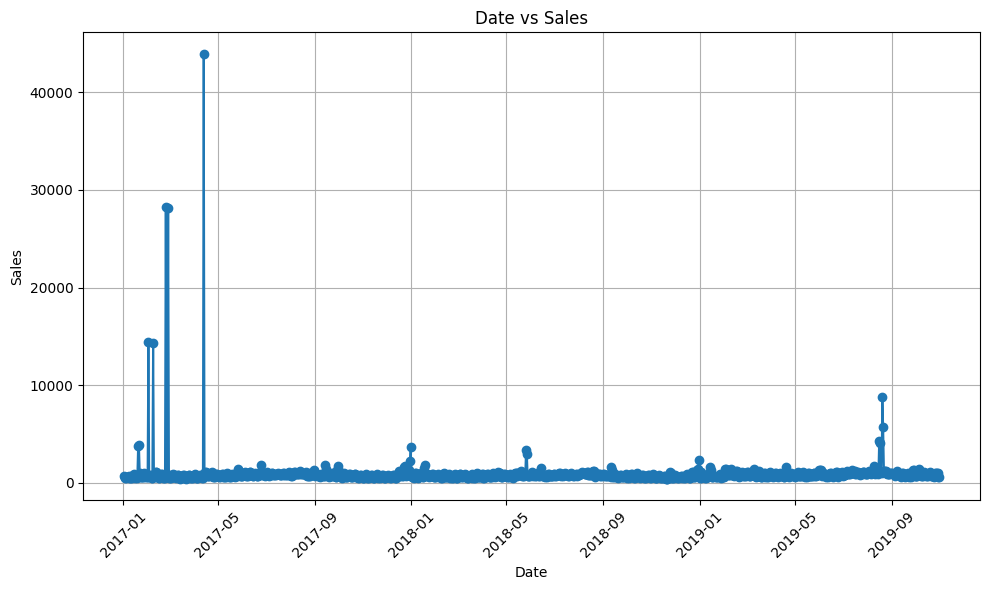

In [22]:
# Convert the 'date' column to datetime type
grouped_df_filtered['date'] = pd.to_datetime(grouped_df_filtered['date'])

# Plot the line graph
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(
    grouped_df_filtered['date'], grouped_df_filtered['sales'],
    marker='o', linestyle='-'
)  
# Plot the line
plt.title('Date vs Sales')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Sales')  # Set the y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot

There are some outliers in the data. we can clearly see the higest points in plot.

In [23]:
# Sort the DataFrame by the 'sales' column in descending order
top_5_sales = grouped_df_filtered.sort_values(by='sales', ascending=False)

# Display the top 5 rows
top_5_sales = top_5_sales.head(5)
top_5_sales

,date,sales
101,2017-04-13,43977.628
53,2017-02-24,28243.060
56,2017-02-27,28163.494
31,2017-02-02,14412.700
37,2017-02-08,14357.122


In [24]:
# Calculate the mean of the 'sales' column
sales_mean = grouped_df_filtered['sales'].mean()

# Replace values in the 'sales' column with the mean if they are higher than 1500
grouped_df_filtered['sales'] = grouped_df_filtered['sales'].mask(grouped_df_filtered['sales'] > 1500, sales_mean)

# Display the DataFrame with replaced values
grouped_df_filtered

,date,sales
0,2017-01-02,712.870
1,2017-01-03,553.594
2,2017-01-04,492.888
3,2017-01-05,481.456
4,2017-01-06,586.036
...,...,...
1028,2019-10-27,988.240
1029,2019-10-28,981.000
1030,2019-10-29,1002.000
1031,2019-10-30,560.000


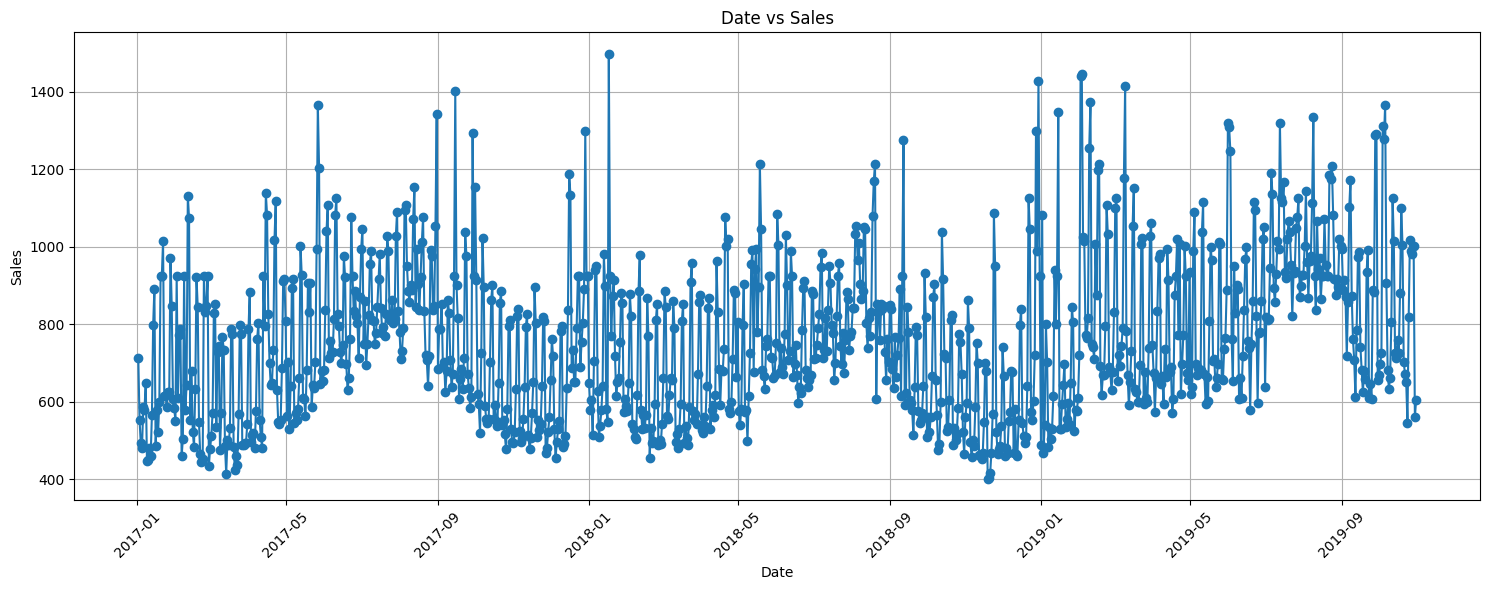

In [25]:
# Convert the 'date' column to datetime type
grouped_df_filtered['date'] = pd.to_datetime(grouped_df_filtered['date'])

# Plot the line graph
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(grouped_df_filtered['date'], grouped_df_filtered['sales'], marker='o', linestyle='-')  # Plot the line
plt.title('Date vs Sales')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Sales')  # Set the y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot

#### Univariant timeseries models backtesting and normalization

##### day

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_sales(data, column_name, forecast_horizon=7, window_size=1000):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=1000, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of weeks to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 7)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = min(len(train), 7)  # Adjusted seasonal periods
        model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [27]:
# Load the data
# data = result_week.copy() 
data = grouped_df_filtered.copy() 

# Call the function
daily_forecast_result = forecast_sales(data, 'sales')

# Print the results
print("Backtesting Error Metrics:")
print(daily_forecast_result['error_metrics'])

print("Final Forecasts for the next 7 days:")
print(daily_forecast_result['forecasts'])

c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
09:09:47 - cmdstanpy - INFO - Chain [1] start processing
09:09:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these argum

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.127724  0.024497
SARIMA   0.101353  0.018158
ETS      0.111383  0.021739
Prophet  0.191269  0.046799
LSTM     0.111230  0.023537
Final Forecasts for the next 7 days:
            ARIMA  SARIMA   ETS  Prophet  LSTM
Date                                          
2019-11-10    813     783   805      941   649
2019-11-17    889    1006  1000      947   704
2019-11-24    918    1013   997      941   797
2019-12-01    975     769   732      917   802
2019-12-08    805     751   709      904   700
2019-12-15    694     719   706      942   611
2019-12-22    745     726   711     1028   630


##### forecast visualization - daily

In [28]:
data = grouped_df_filtered.copy()
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

plt.plot(data['Date'], data['Bottles Sold'], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in daily_forecast_result['forecasts'].columns:
    plt.plot(daily_forecast_result['forecasts'].index, daily_forecast_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

KeyError: 'Date'

<Figure size 1000x600 with 0 Axes>

##### week

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_week_sales(data, column_name, forecast_horizon=7, window_size=100):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into weekly sums
    data.set_index('date', inplace=True)
    data = data.resample('W').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=100, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of weeks to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 52)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 4  # Adjusted seasonal periods
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [31]:
# Load the data
data = grouped_df_filtered.copy() 

# Call the function
week_sales_forecast_result = forecast_week_sales(data, 'sales')

# Print the results
print("Backtesting Error Metrics:")
print(week_sales_forecast_result['error_metrics'])

print("Final Forecasts for the next 7 weeks:")
print(week_sales_forecast_result['forecasts'])

c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
09:56:34 - cmdstanpy - INFO - Chain [1] start processing
09:56:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `worke

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.154991  0.039136
SARIMA   0.171232  0.051924
ETS      0.159907  0.040748
Prophet  0.188240  0.051690
LSTM     0.157133  0.043336
Final Forecasts for the next 7 weeks:
            ARIMA  SARIMA   ETS  Prophet  LSTM
Date                                          
2019-11-10   4042    3837  3865     4681  4752
2019-11-17   4387    4192  3876     4811  4710
2019-11-24   4283    4710  3967     4784  4660
2019-12-01   4543    4468  3937     4656  4634
2019-12-08   4342    4490  3865     4731  4607
2019-12-15   4276    5119  3876     5189  4647
2019-12-22   4345    5586  3967     5806  4770


##### forecast visualization - week

In [ ]:
data = grouped_df_filtered.copy()
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Set 'date' as the index
data.set_index('date', inplace=True)

# Resample by week and aggregate using sum
df_weekly = data.resample('W').sum()

df_weekly.reset_index(inplace=True)

plt.plot(df_weekly['date'], df_weekly['sold_qty'], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in week_sales_forecast_result['forecasts'].columns:
    plt.plot(week_sales_forecast_result['forecasts'].index, week_sales_forecast_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

##### month

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_monthly_sales(data, column_name, forecast_horizon=6, window_size=25):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of months to forecast. Default is 6.
    window_size (int): Size of the sliding window for backtesting in months. Default is 6.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into monthly sums
    data.set_index('date', inplace=True)
    data = data.resample('MS').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=25, forecast_horizon=6):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of months to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        cumulative_length = 0  # Initialize cumulative length counter

        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            cumulative_length += len(train)
            print(f"Length of training data in iteration {i+1}: {len(train)}, Cumulative length: {cumulative_length}")
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 12)  # Monthly seasonality
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 12  # Monthly seasonality
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='MS')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of months to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.DateOffset(months=1), periods=forecast_horizon, freq='MS')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            if isinstance(forecast_values, np.ndarray):
                forecast_df[model] = scaler.inverse_transform(forecast_values.reshape(-1, 1)).flatten().astype(int)
            else:
                forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [34]:
# Load the data
data = grouped_df_filtered.copy() 

# Call the function
monthly_sales_result = forecast_monthly_sales(data, 'sales')

# Print the results
print("Backtesting Error Metrics:")
print(monthly_sales_result['error_metrics'])

print("Final Forecasts for the next 6 months:")
print(monthly_sales_result['forecasts'])

Length of training data in iteration 1: 25, Cumulative length: 25


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
10:23:45 - cmdstanpy - INFO - Chain [1] start processing
10:23:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `worke

Length of training data in iteration 2: 25, Cumulative length: 50


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
10:23:52 - cmdstanpy - INFO - Chain [1] start processing
10:23:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `worke

Length of training data in iteration 3: 25, Cumulative length: 75


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
10:23:58 - cmdstanpy - INFO - Chain [1] start processing
10:23:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-

Length of training data in iteration 4: 25, Cumulative length: 100


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
10:24:04 - cmdstanpy - INFO - Chain [1] start processing
10:24:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.342568  0.156904
SARIMA   0.242480  0.087812
ETS      0.241434  0.079426
Prophet  0.295105  0.129717
LSTM     0.332381  0.151656
Final Forecasts for the next 6 months:
            ARIMA  SARIMA    ETS  Prophet   LSTM
Date                                            
2019-11-01  26779   22408  21874    18567  25241
2019-12-01  27934   26424  26029    20969  25084
2020-01-01  27783   25662  25041    22129  24891
2020-02-01  27458   24468  24857    26082  24768
2020-03-01  27195   25362  25133    20120  24764
2020-04-01  27254   26282  25829    26630  24766


##### forecast visulaization - month

In [ ]:
data = grouped_df_filtered.copy()
# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

# Set 'date' as the index
data.set_index('date', inplace=True)

# Resample by week and aggregate using sum
df_weekly = data.resample('M').sum()

df_weekly.reset_index(inplace=True)

plt.plot(df_weekly['date'], df_weekly['sold_qty'], marker='o', linestyle='-', color='b')

# Plot each model's forecasted values
for col in monthly_sales_result['forecasts'].columns:
    plt.plot(monthly_sales_result['forecasts'].index, monthly_sales_result['forecasts'][col], marker='o', linestyle='-', label=col)

# Formatting
plt.title('Sold Quantity Over Time')
plt.xlabel('Date')
plt.ylabel('Sold Quantity')
plt.grid(True)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

#### multi variant timeseries 

In [36]:
df_filtered

,product_id,store_id,date,sales
0,P0103,S0001,2017-01-02,13.0
1,P0103,S0002,2017-01-02,5.0
2,P0103,S0020,2017-01-02,16.0
3,P0103,S0023,2017-01-02,2.0
4,P0103,S0024,2017-01-02,5.0
...,...,...,...,...
313718,P0747,S0108,2019-12-29,NaN
313719,P0747,S0110,2019-12-29,NaN
313720,P0747,S0112,2019-12-29,NaN
313721,P0747,S0115,2019-12-29,NaN


In [37]:
# Count the number of zeros in the 'sales' column
zero_count = (df_filtered['sales'] == 0).sum()

# Print the result
print("Number of zeros in the sales column:", zero_count)

Number of zeros in the sales column: 121062


In [38]:
# Convert 'date' column to datetime if it's not already
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Filter out rows where month is not 11 or 12 in the year 2019
mask = (df_filtered['date'].dt.year == 2019) & (df_filtered['date'].dt.month.isin([11, 12]))
df_filtered_month_removed = df_filtered[~mask]

# Check the shape of the filtered DataFrame
print(df_filtered_month_removed.shape)


(296574, 4)


In [39]:
df_filtered_month_removed

,product_id,store_id,date,sales
0,P0103,S0001,2017-01-02,13.0
1,P0103,S0002,2017-01-02,5.0
2,P0103,S0020,2017-01-02,16.0
3,P0103,S0023,2017-01-02,2.0
4,P0103,S0024,2017-01-02,5.0
...,...,...,...,...
296569,P0747,S0108,2019-10-31,0.0
296570,P0747,S0110,2019-10-31,0.0
296571,P0747,S0112,2019-10-31,0.0
296572,P0747,S0115,2019-10-31,0.0


In [40]:
# Create a new column combining product_id and store_id
df_filtered_month_removed['combined_id'] = df_filtered_month_removed['product_id'] + '_' + df_filtered_month_removed['store_id']

# Pivot the DataFrame
pivot_df = df_filtered_month_removed.pivot_table(index='date', columns='combined_id', values='sales', fill_value=0)

# Reset the index
pivot_df.reset_index(inplace=True)

# Display the modified DataFrame
pivot_df.head()

C:\Users\yeswa\AppData\Local\Temp\ipykernel_13892\4268429089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_month_removed['combined_id'] = df_filtered_month_removed['product_id'] + '_' + df_filtered_month_removed['store_id']


combined_id,date,P0103_S0001,P0103_S0002,P0103_S0020,P0103_S0023,P0103_S0024,P0103_S0026,P0103_S0028,P0103_S0031,P0103_S0038,...,P0747_S0085,P0747_S0094,P0747_S0095,P0747_S0097,P0747_S0104,P0747_S0108,P0747_S0110,P0747_S0112,P0747_S0115,P0747_S0126
0,2017-01-02,13.0,5.0,16.0,2.0,5.0,0.0,14.0,10.0,6.0,...,3.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,2.0
1,2017-01-03,8.0,4.0,18.0,7.0,14.0,0.0,7.0,6.0,3.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2017-01-04,7.0,4.0,12.0,4.0,14.0,0.0,20.0,4.0,7.0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-05,10.0,6.0,17.0,6.0,11.0,0.0,12.0,6.0,6.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
4,2017-01-06,8.0,6.0,20.0,6.0,14.0,0.0,23.0,9.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:
pivot_df.shape

(1033, 368)

In [42]:
pivot_df.tail()

combined_id,date,P0103_S0001,P0103_S0002,P0103_S0020,P0103_S0023,P0103_S0024,P0103_S0026,P0103_S0028,P0103_S0031,P0103_S0038,...,P0747_S0085,P0747_S0094,P0747_S0095,P0747_S0097,P0747_S0104,P0747_S0108,P0747_S0110,P0747_S0112,P0747_S0115,P0747_S0126
1028,2019-10-27,25.0,10.0,17.0,5.0,24.0,10.0,22.0,24.0,10.0,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1029,2019-10-28,9.0,6.0,14.0,9.0,16.0,15.0,12.0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030,2019-10-29,8.0,5.0,10.0,6.0,13.0,8.0,15.0,10.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1031,2019-10-30,11.0,4.0,12.0,6.0,7.0,3.0,5.0,6.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
1032,2019-10-31,12.0,9.0,17.0,2.0,8.0,5.0,9.0,11.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
restricted_df = pivot_df.iloc[:, :7] 
restricted_df 

combined_id,date,P0103_S0001,P0103_S0002,P0103_S0020,P0103_S0023,P0103_S0024,P0103_S0026
0,2017-01-02,13.0,5.0,16.0,2.0,5.0,0.0
1,2017-01-03,8.0,4.0,18.0,7.0,14.0,0.0
2,2017-01-04,7.0,4.0,12.0,4.0,14.0,0.0
3,2017-01-05,10.0,6.0,17.0,6.0,11.0,0.0
4,2017-01-06,8.0,6.0,20.0,6.0,14.0,0.0
...,...,...,...,...,...,...,...
1028,2019-10-27,25.0,10.0,17.0,5.0,24.0,10.0
1029,2019-10-28,9.0,6.0,14.0,9.0,16.0,15.0
1030,2019-10-29,8.0,5.0,10.0,6.0,13.0,8.0
1031,2019-10-30,11.0,4.0,12.0,6.0,7.0,3.0


#### Vector Autoregression (VAR) model

In [44]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error

def prepare_and_forecast(pivot_df):
    # Step 1: Prepare the data
    # Convert 'Date' column to datetime if it's not already in datetime format
    pivot_df['date'] = pd.to_datetime(pivot_df['date'])
    data = pivot_df.set_index('date')

    # Normalize the data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_data_df = pd.DataFrame(normalized_data, columns=data.columns, index=data.index)

    # Fit VAR model
    model = VAR(normalized_data_df)
    order = 1  # Adjust as needed
    results = model.fit(order)

    # Forecast future values for the next 7 days
    forecast = results.forecast(normalized_data_df.values[-order:], steps=7)

    # Step 4: Create a DataFrame with forecasted dates and sales values
    forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

    # Inverse transform the forecasted values to the original scale
    forecast_inversed = scaler.inverse_transform(forecast)
    forecast_inversed_df = pd.DataFrame(forecast_inversed.round().astype(int), index=forecast_dates, columns=data.columns)

    # Calculate error metrics with normalized values
    # Get actual values for the forecast period
    actual_values = normalized_data_df.iloc[-7:]

    # Calculate Mean Absolute Error (MAE) with normalized values
    mae_normalized = mean_absolute_error(actual_values, forecast)

    # Calculate Mean Squared Error (MSE) with normalized values
    mse_normalized = mean_squared_error(actual_values, forecast)

    # Display error metrics
    print("Mean Absolute Error (MAE) with normalized values:", mae_normalized)
    print("Mean Squared Error (MSE) with normalized values:", mse_normalized)

    # Concatenate the original DataFrame with the forecasted DataFrame
    combined_df = pd.concat([data, forecast_inversed_df])

    # Reset index and drop the combined_id index
    combined_df.reset_index(inplace=True)
    
    # Set the new index from the 'index' column and drop the 'index' column
    combined_df.set_index('index', inplace=True)
    combined_df.index.name = None  # Optionally remove the index name

    return combined_df

# Call the function with the pivot_df DataFrame
combined_df = prepare_and_forecast(pivot_df.iloc[:, :7])

# Display the combined DataFrame with forecasted dates and values
combined_df.tail(7)


Mean Absolute Error (MAE) with normalized values: 0.04224820919623488
Mean Squared Error (MSE) with normalized values: 0.0030793461418807465


c:\Users\yeswa\OneDrive\Desktop\time_series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


combined_id,P0103_S0001,P0103_S0002,P0103_S0020,P0103_S0023,P0103_S0024,P0103_S0026
2019-11-01,14.0,9.0,14.0,6.0,12.0,10.0
2019-11-02,15.0,9.0,14.0,6.0,14.0,12.0
2019-11-03,16.0,9.0,14.0,6.0,15.0,12.0
2019-11-04,16.0,9.0,14.0,7.0,15.0,12.0
2019-11-05,17.0,9.0,14.0,7.0,15.0,13.0
2019-11-06,17.0,9.0,14.0,7.0,15.0,13.0
2019-11-07,17.0,9.0,14.0,7.0,15.0,13.0


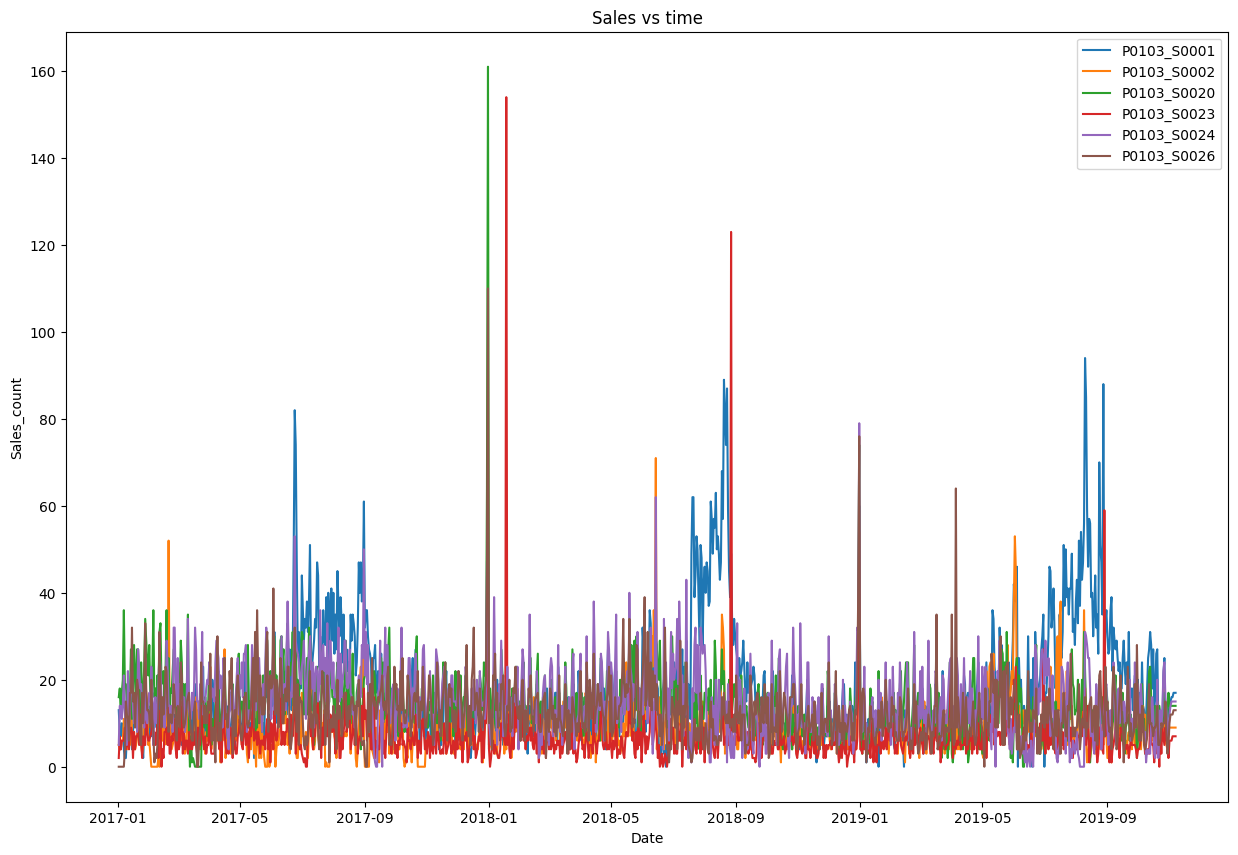

In [ ]:
# Plotting the lines
plt.figure(figsize=(15, 10))
for col in combined_df.columns:
    plt.plot(combined_df.index, combined_df[col], label=col)

# single column
# plt.plot(combined_df.index, combined_df['P0103_S0001'], label=col)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales_count')
plt.title('Sales vs time')
plt.legend()
plt.show()